In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Nayatel1234.",
    database="retail_forecasting"
)

In [3]:
query = "SELECT * FROM clean_forecasting_data"
df = pd.read_sql(query, mydb)

/var/folders/pd/ytcd7z3x2hddb0t98zp6vtrc0000gn/T/ipykernel_4684/1931268912.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, mydb)


In [4]:
df.head()

,date,store_nbr,family,sales,onpromotion,transactions,oil_prices,holiday_event,city,state
0,2013-01-01,25,AUTOMOTIVE,0,0,770.0,93.14,Primer dia del ano,Salinas,Santa Elena
1,2013-01-01,25,BABY CARE,0,0,770.0,93.14,Primer dia del ano,Salinas,Santa Elena
2,2013-01-01,25,BEAUTY,2,0,770.0,93.14,Primer dia del ano,Salinas,Santa Elena
3,2013-01-01,25,BEVERAGES,810,0,770.0,93.14,Primer dia del ano,Salinas,Santa Elena
4,2013-01-01,25,BOOKS,0,0,770.0,93.14,Primer dia del ano,Salinas,Santa Elena


In [5]:
df.dtypes

date              object
store_nbr          int64
family            object
sales              int64
onpromotion        int64
transactions     float64
oil_prices       float64
holiday_event     object
city              object
state             object
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")

In [7]:
df.dtypes

date             datetime64[ns]
store_nbr                 int64
family                   object
sales                     int64
onpromotion               int64
transactions            float64
oil_prices              float64
holiday_event            object
city                     object
state                    object
dtype: object

In [8]:
df.shape

(3054348, 10)

In [9]:
df.describe()

,date,store_nbr,sales,onpromotion,transactions,oil_prices
count,3054348,3.054348e+06,3.054348e+06,3.054348e+06,2.805231e+06,2.175822e+06
mean,2015-04-26 12:11:45.717620480,2.750000e+01,3.590208e+02,2.617480e+00,1.697071e+03,6.795358e+01
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,2.619000e+01
25%,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,1.046000e+03,4.646000e+01
50%,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,1.395000e+03,5.341000e+01
75%,2016-06-22 00:00:00,4.100000e+01,1.960000e+02,0.000000e+00,2.081000e+03,9.580000e+01
max,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02
std,NaN,1.558579e+01,1.107286e+03,1.225494e+01,9.668317e+02,2.566958e+01


<Axes: >

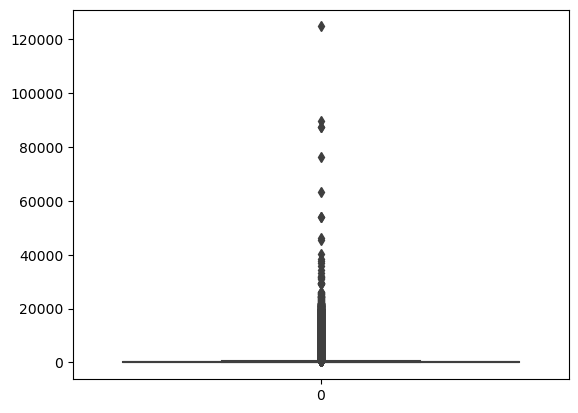

In [11]:
#to see outliers clearly
import seaborn as sns
sns.boxplot(df['sales'])

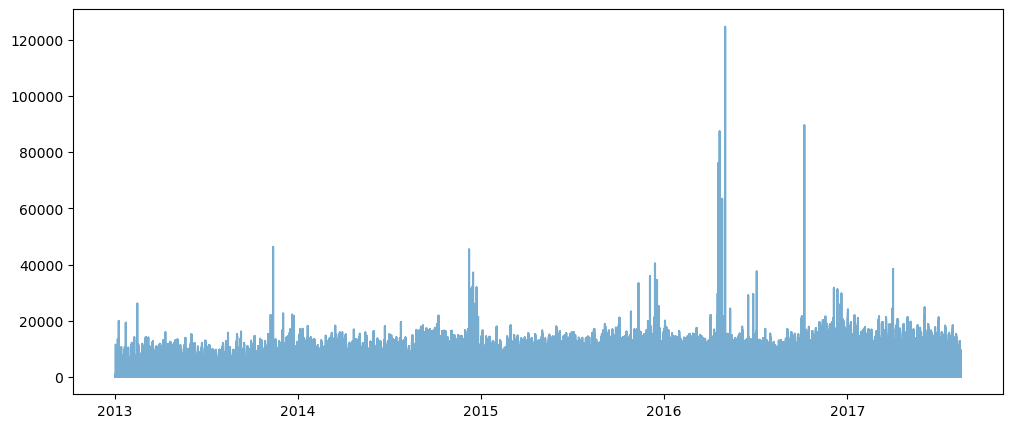

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['sales'], alpha=0.6)
plt.show()

In [13]:
#find the limits
upper_limit = df['sales'].mean() + 3*df['sales'].std()
lower_limit = df['sales'].mean() - 3*df['sales'].std()
print('upper_limit: ', upper_limit)
print('lower_limit: ', lower_limit)

upper_limit:  3680.8785867406855
lower_limit:  -2962.8369294049794


In [14]:
#find the outliers
df.loc[(df['sales'] > upper_limit) | (df['sales'] < lower_limit)]

,date,store_nbr,family,sales,onpromotion,transactions,oil_prices,holiday_event,city,state
111,2013-01-02,11,GROCERY I,7736,0,3547.0,93.14,None,Cayambe,Pichincha
342,2013-01-02,18,GROCERY I,3756,0,1635.0,93.14,None,Quito,Pichincha
408,2013-01-02,2,GROCERY I,3870,0,2358.0,93.14,None,Quito,Pichincha
474,2013-01-02,24,GROCERY I,3920,0,2605.0,93.14,None,Guayaquil,Guayas
630,2013-01-02,3,BEVERAGES,4486,0,3487.0,93.14,None,Quito,Pichincha
...,...,...,...,...,...,...,...,...,...,...
3054153,2017-08-01,47,BEVERAGES,8636,31,3846.0,49.19,None,Quito,Pichincha
3054162,2017-08-01,47,GROCERY I,12456,62,3846.0,49.19,None,Quito,Pichincha
3054180,2017-08-01,47,PRODUCE,5694,15,3846.0,49.19,None,Quito,Pichincha
3054195,2017-08-03,29,GROCERY I,4251,68,1139.0,49.03,None,Guayaquil,Guayas


In [15]:
#capping - change the outlier values to upper or lower limit values
new_data = df.copy()
new_data.loc[new_data['sales']>upper_limit, 'sales'] = upper_limit
new_data.loc[new_data['sales']<lower_limit, 'sales'] = lower_limit

<Axes: >

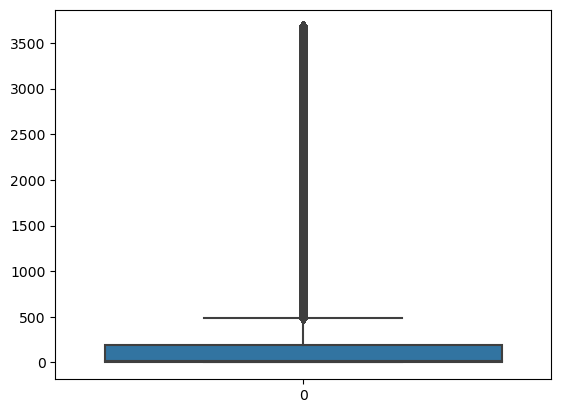

In [16]:
sns.boxplot(new_data['sales'])

In [17]:
new_data.to_csv("clean_data.csv", index=False)

In [18]:
new_data.describe()

,date,store_nbr,sales,onpromotion,transactions,oil_prices
count,3054348,3.054348e+06,3.054348e+06,3.054348e+06,2.805231e+06,2.175822e+06
mean,2015-04-26 12:11:45.717620480,2.750000e+01,3.037042e+02,2.617480e+00,1.697071e+03,6.795358e+01
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,2.619000e+01
25%,2014-03-01 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00,1.046000e+03,4.646000e+01
50%,2015-04-28 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,1.395000e+03,5.341000e+01
75%,2016-06-22 00:00:00,4.100000e+01,1.960000e+02,0.000000e+00,2.081000e+03,9.580000e+01
max,2017-08-15 00:00:00,5.400000e+01,3.680879e+03,7.410000e+02,8.359000e+03,1.106200e+02
std,NaN,1.558579e+01,7.338169e+02,1.225494e+01,9.668317e+02,2.566958e+01


In [19]:
new_df = pd.get_dummies(new_data, columns=['holiday_event', 'family'], drop_first=True)

In [21]:
cols_to_agg = ['sales', 'onpromotion', 'store_nbr'] + [c for c in new_df.columns if 'holiday_event_' in c or 'family_' in c]
df_daily = new_df.groupby('date')[cols_to_agg].sum().reset_index()
df_daily.rename(columns={'date':'ds', 'sales':'y'}, inplace=True)

In [22]:
model = Prophet()

In [23]:
model.add_regressor('onpromotion')
model.add_regressor('store_nbr')
for c in df_daily.columns:
    if 'holiday_event_' in c or 'family_' in c:
        model.add_regressor(c)

In [24]:
model.fit(df_daily)

11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:37 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = model.make_future_dataframe(periods=180)

In [27]:
future['onpromotion'] = df_daily['onpromotion'].iloc[-1]
future['store_nbr'] = df_daily['store_nbr'].iloc[-1]
for c in df_daily.columns:
    if 'holiday_event_' in c or 'family_' in c:
        future[c] = df_daily[c].mode()[0]

/var/folders/pd/ytcd7z3x2hddb0t98zp6vtrc0000gn/T/ipykernel_4684/3916645883.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[c] = df_daily[c].mode()[0]
/var/folders/pd/ytcd7z3x2hddb0t98zp6vtrc0000gn/T/ipykernel_4684/3916645883.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[c] = df_daily[c].mode()[0]
/var/folders/pd/ytcd7z3x2hddb0t98zp6vtrc0000gn/T/ipykernel_4684/3916645883.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [28]:
forecast = model.predict(future)

/Users/Famille/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1275: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['trend'] = self.predict_trend(df)


In [30]:
future_forecast = forecast.iloc[-180:]
print("Sum of forecast (next 180 days):", future_forecast['yhat'].sum())

Sum of forecast (next 180 days): 131333811.77699332


In [31]:
print("Sum of forecast:", forecast['yhat'].sum())

Sum of forecast: 1110801341.6077476


In [32]:
forecast_clean = future_forecast[['ds','yhat','yhat_lower','yhat_upper','trend','weekly','yearly']].copy()
forecast_clean.rename(columns={
    'ds':'forecast_date',
    'yhat':'forecast',
    'yhat_lower':'forecast_lower',
    'yhat_upper':'forecast_upper',
    'weekly':'weekly_seasonality',
    'yearly':'yearly_seasonality'
}, inplace=True)
forecast_clean.to_csv("forecast_data.csv", index=False)

In [33]:
forecast_clean = forecast[['ds','yhat','yhat_lower','yhat_upper','trend','weekly','yearly']].copy()
forecast_clean.rename(columns={
    'ds':'forecast_date',
    'yhat':'forecast',
    'yhat_lower':'forecast_lower',
    'yhat_upper':'forecast_upper',
    'weekly':'weekly_seasonality',
    'yearly':'yearly_seasonality'
}, inplace=True)
forecast_clean.to_csv("forecast_all_data.csv", index=False)

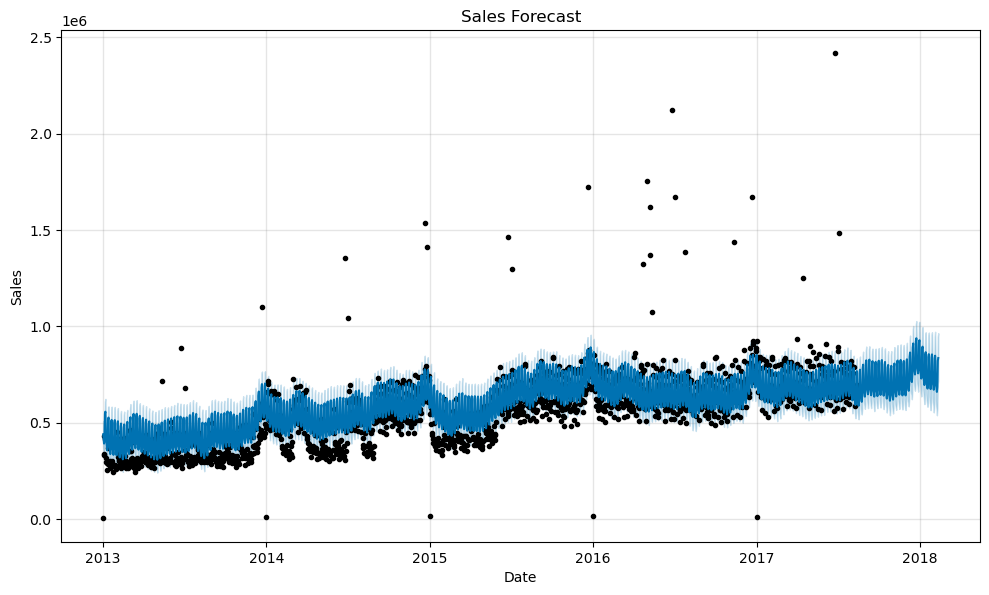

In [34]:
model.plot(forecast)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()